In [1]:
from __future__ import division, print_function

import pickle

import numpy as np
from scipy.spatial import cKDTree
from scipy import stats, special

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates.angles import rotation_matrix

from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.cosmology import WMAP9

In [51]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import rcParams, animation
from matplotlib import transforms as mtransforms
from mpl_toolkits.mplot3d import Axes3D

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [102]:
def mag2lmstar(mag, mag_sun=4.65, mtol=1):
    mag = np.array(mag, copy=False)
    return (mag - mag_sun)/-2.5 + np.log10(mtol)

In [3]:
with open('NearbyGalaxies.dat') as f:
    galstr = f.read()
    
print(galstr)

This file contains an updated list of all observational parameters
originally presented in McConnachie (2012, AJ, 144, 4).  

** Please refer to the main paper for more details on each parameter **

** Please see  supplementary file "Update.log" for a record of recent changes and the date of the last update **
** Please see supplementary file "References.dat" for a numbered list of all references (final column of this file) **
** Please let me know via email if you spot any errors or omissions in this file **

** Systems with an asterix (*) preceding their name are objects whose nature (globular cluster, dwarf galaxy, tidal remnant, asterism, etc) is ambiguous

** Systems where the parameter value is listed as "nines" indicate that no value is known **
** Systems where the parameter has a value but the errors are listed as "nines" indicate that the parameter value is highly uncertain **
** (Note that the information for the non-dwarf galaxies - the Galaxy, M31, M33, NGC55, NGC300 - and

In [40]:
sfingdct = {'And XXX': False,
 'And XXXI': False,
 'And XXXII': False,
 'Andromeda': True,
 'Andromeda I': False,
 'Andromeda II': False,
 'Andromeda III': False,
 'Andromeda IX': False,
 'Andromeda V': False,
 'Andromeda VI': False,
 'Andromeda VII': False,
 'Andromeda X': False,
 'Andromeda XI': False,
 'Andromeda XII': False,
 'Andromeda XIII': False,
 'Andromeda XIV': False,
 'Andromeda XIX': False,
 'Andromeda XV': False,
 'Andromeda XVI': False,
 'Andromeda XVII': False,
 'Andromeda XVIII': False,
 'Andromeda XX': False,
 'Andromeda XXI': False,
 'Andromeda XXII': False,
 'Andromeda XXIII': False,
 'Andromeda XXIV': False,
 'Andromeda XXIX': False,
 'Andromeda XXV': False,
 'Andromeda XXVI': False,
 'Andromeda XXVII': False,
 'Andromeda XXVIII': False,
 'Antlia': True,
 'Aquarius': True,
 'Bootes (I)': False,
 'Bootes II': False,
 'Bootes III': False,
 'Canes Venatici (I)': False,
 'Canes Venatici II': False,
 'Canis Major': False,
 'Carina': False,
 'Cetus': False,
 'Coma Berenices': False,
 'DDO 113': True,
 'DDO 125': True,
 'DDO 190': True,
 'DDO 99': True,
 'Draco': False,
 'ESO 294- G 010': False,
 'ESO 410- G 005': False,
 'Fornax': False,
 'GR 8': True,
 'HIZSS 3(A)': True,
 'HIZSS 3B': True,
 'Hercules': False,
 'IC 10': True,
 'IC 1613': True,
 'IC 3104': True,
 'IC 4662': True,
 'IC 5152': True,
 'KKH 86': True,
 'KKH 98': True,
 'KKR 25': False,
 'KKR 3': True,
 'LGS 3': True,
 'LMC': True,
 'Leo A': True,
 'Leo I': False,
 'Leo II': False,
 'Leo IV': False,
 'Leo P': True,
 'Leo T': True,
 'Leo V': False,
 'M32': False,
 'NGC 147': False,
 'NGC 185': False,
 'NGC 205': False,
 'NGC 300': True,
 'NGC 3109': True,
 'NGC 4163': True,
 'NGC 55': True,
 'NGC 6822': True,
 'Pegasus dIrr': True,
 'Phoenix': True,
 'Pisces II': False,
 'SMC': True,
 'Sagittarius dIrr': True,
 'Sagittarius dSph': False,
 'Sculptor': False,
 'Segue (I)': False,
 'Segue II': False,
 'Sextans (I)': False,
 'Sextans A': True,
 'Sextans B': True,
 'The Galaxy': True,
 'Triangulum': True,
 'Tucana': False,
 'UGC 4879': True,
 'UGC 8508': True,
 'UGC 9128': True,
 'UGCA 86': True,
 'UKS 2323-326': True,
 'Ursa Major (I)': False,
 'Ursa Major II': False,
 'Ursa Minor': False,
 'WLM': True,
 'Willman 1': False}

In [72]:
intab = False

nms = []
MVs = []
MHIs = []

for l in galstr.split('\n'):
    if l.strip() == '':
        continue
    if intab:
        nms.append(l[:19].strip())
        MHI = float(l[185:190])
        MHIs.append(1 if MHI==0 or MHI==99.9 else (MHI*1e6))
        Vmag = float(l[79:84])
        dm = float(l[45:51])
        EBV = float(l[39:45])
        MVs.append(Vmag - dm - EBV*3.1)
    elif l.startswith('123456789012345678901234567'):
        intab = True

In [73]:
sfingMV = []
sfingMHI = []
passiveMV = []
passiveMHI = []

nmsfound = []
for nm, b in sfingdct.items():
    try:
        i = nms.index(nm)
        nmsfound.append(nm)
        
        if b:
            sfingMV.append(MVs[i])
            sfingMHI.append(MHIs[i])
        else:
            passiveMV.append(MVs[i])
            passiveMHI.append(MHIs[i])
    except ValueError as e:
        print(e)
        
nmsc = nms[:]
for nm in nmsfound:
    nmsc.pop(nmsc.index(nm))
if len(nmsc) > 0:
    print('Did not find', nmsc)

'Bootes III' is not in list
'Canis Major' is not in list
Did not find ['*Canis Major', '*Tucana III', '*Draco II', '*Reticulum 2', '*Cetus II', '*Triangulum II', '*Tucana IV', '*Bootes III', '*Grus II', '*Tucana V', 'Tucana 2', '*Sagittarius II', '*Horologium II', '*Horologium 1', '*Eridanus 3', '*Phoenix 2', '*Reticulum III', '*Indus 1', '*Grus 1', '*Pictoris 1', 'Hydra II', '*Columba I', '*Pegasus 3', '*Indus I ?', 'And XXXIII', 'Eridanus 2', 'Antlia B', 'KK 258', 'KKs3']


In [74]:
#post McQuinn 2015
leopdist = 1.62*u.Mpc
rratio = leopdist/(1.72*u.Mpc)

leopmstar=5.6e5 * u.solMass
leopMHI=8.1e5 * u.solMass
leopMV = -9.27*u.mag
leopRelim = rratio*0.58*u.kpc  #that's the "Semimajor axis", which isn't really Re
leopRe = rratio*.188*u.kpc #from below

In [78]:
piscsMV = [-11.6,-12.9]
piscsMHI = np.array([8.9, 30])*1e6

In [111]:
## import data for SHIELD galaxies from Cannon+ 11
shieldtabstr="""
Table 1
VLA/EVLA Observations of ALFALFA-selected Low-mass Dwarf Galaxies

AGC^a	alpha	delta	Distance	M_r	(u - r)	M_B	(B - V)	%Z_sun^b	V_21	W_21	log (M_H i)	
	(J2000)	(J2000)	(Mpc)	(mag)	(mag)	(mag)	(mag)		(km s^-1)	(km s^-1)	(M_sun)	
Concept demonstration targets	
100062	00:09:52.8	15:43:58	12.7^c	-15.02	1.02 +or- 0.02	N/A	N/A	N/A	869	45	7.82	
101772	00:11:08.2	14:14:08	11.7^c	-13.64	0.98 +or- 0.06	N/A	N/A	N/A	802	37	7.54	
111945	01:44:42.7	27:17:18	6.3^c	-11.88^d	3.35 +or- 1.26^d	N/A	N/A	N/A	420	38	7.28	
321203	22:13:03.3	28:04:28	16.4^c	-14.20	0.98 +or- 0.04	N/A	N/A	14%	983	62	7.83	
321307	22:14:04.4	25:41:08	18.7^c	-13.88	1.24 +or- 0.07	N/A	N/A	N/A	1152	60	7.96	
332939	23:08:16.0	31:53:57	11.4^c	-13.67	0.69 +or- 0.05	N/A	N/A	N/A	692	41	7.74	
	
The SHIELD sample	
748778^e	00:06:34.3	15:30:39	5.4^c	-10.52	0.81 +or- 0.19	-10.02	0.25 +or- 0.03	N/A	258	16	6.51	
112521^e	01:41:07.6	27:19:24	7.2^f	-11.52^d	2.19 +or- 0.42^d	-10.80	0.45 +or- 0.03	6%	274	26	6.92	
110482^e	01:42:17.4	26:22:00	7.2^f	-13.63	1.25 +or- 0.04	-12.86	0.49 +or- 0.02	13%	357	30	7.21	
111946^e	01:46:42.2	26:48:05	7.2^f	-11.49^d	1.46 +or- 0.25^d	-11.48	0.39 +or- 0.03	5%	367	21	6.97	
111977^e	01:55:20.2	27:57:14	5.5^g	-12.55^d	2.26 +or- 0.16^d	-12.31	0.47 +or- 0.02	N/A	207	26	6.78	
111164^e	02:00:10.1	28:49:52	4.9^g	-11.50^d	0.80 +or- 0.09^d	-11.10	0.41 +or- 0.02	N/A	163	27	6.57	
174585^h,^i	07:36:10.3	09:59:11	6.1^c	N/A	N/A	N/A	N/A	N/A	356	21	6.68	
174605^h	07:50:21.7	07:47:40	6.0^c	-10.46^d	1.85 +or- 0.21^d	-10.98	0.47 +or- 0.05	N/A	351	24	6.75	
182595^h	08:51:12.1	27:52:48	6.1^c	-12.45	1.27 +or- 0.05	-11.75	0.52 +or- 0.05	N/A	398	20	6.66	
731457^h	10:31:55.8	28:01:33	5.4^c	-12.55	1.23 +or- 0.03	-12.02	0.39 +or- 0.05	N/A	454	36	6.63	
749237^h	12:26:23.4	27:44:44	3.2^c	-11.58	1.28 +or- 0.03	-11.21	0.44 +or- 0.05	N/A	372	65	6.64	
749241^h	12:40:01.7	26:19:19	4.3^c	-9.27	0.83 +or- 0.15	-9.57	0.22 +or- 0.05	N/A	451	18	6.52	

Notes.
a Arecibo General Catalog.
b Assuming the solar oxygen abundance from Asplund et al. (2009).
c Derived using the parametric multiattractor flow model developed by Masters (2005); see further discussion in Martin et al. (2010).
d Magnitudes and colors uncertain due to SDSS shredding issues.
e WIYN 3.5 m imaging acquired in Fall 2010.
f Probable member of NGC 672 group.
g Tip of the red giant branch.
h WIYN 3.5 m imaging acquired in Spring 2011.
i AGC 174585 is outside the SDSS footprint; an absolute calibration of the WIYN 3.5 m observations awaits subsequent re-imaging.
"""[1:-1]

indat = False
shinum = []
#shiMr = []
shiMB = []
shiBmV = []
shilMHI = []
shiw50 = []
for ln in shieldtabstr.split('\n'):
    if ln.startswith('Concept demonstration targets') or ln.startswith('The SHIELD sample'):
        indat = True
    elif indat:
        if ln.strip() == '':
            indat = False
        else:
            lns = ln.strip().split('\t')
            #if lns[4] != 'N/A':
            if lns[6] != 'N/A':
                shinum.append(int(lns[0].split('^')[0]))
                #shiMr.append(float(lns[4].split('^')[0]))
                shiMB.append(float(lns[6].split('^')[0]))
                shiBmV.append(float(lns[7].split(' +')[0]))
                shilMHI.append(float(lns[-1]))
                shiw50.append(float(lns[-2]))

shinum = np.array(shinum)
#shiMr = np.array(shiMr)
shiMB = np.array(shiMB)
shiBmV = np.array(shiBmV)
shiMV = shiMB - shiBmV
shilMHI = 10**np.array(shilMHI)
shiw50 = np.array(shiw50)     
shilMstar = mag2lmstar(shiMr)

# Plots 

/home/erik/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


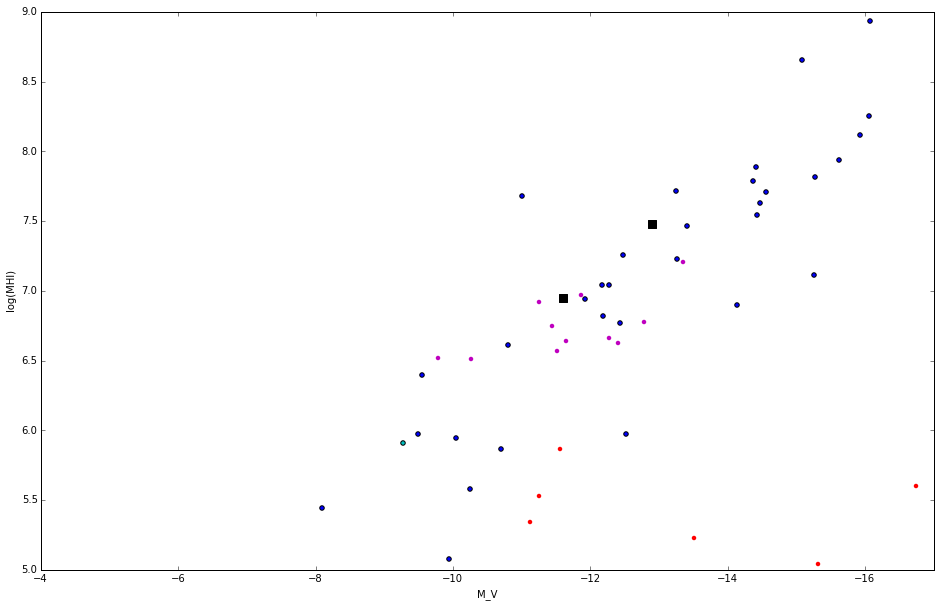

In [115]:
plt.scatter(sfingMV, np.log10(sfingMHI), c='b')
plt.scatter(passiveMV, np.log10(passiveMHI), c='r', lw=0)
plt.scatter([leopMV.value], np.log10([leopMHI.value]), c='c')
plt.scatter(shiMV, np.log10(shilMHI), c='m',lw=0)
plt.scatter(piscsMV, np.log10(piscsMHI), c='k',s=60, marker='s')
plt.xlim(-4, -17)
plt.ylim(5,9)
plt.xlabel('M_V')
plt.ylabel('log(MHI)')

/home/erik/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


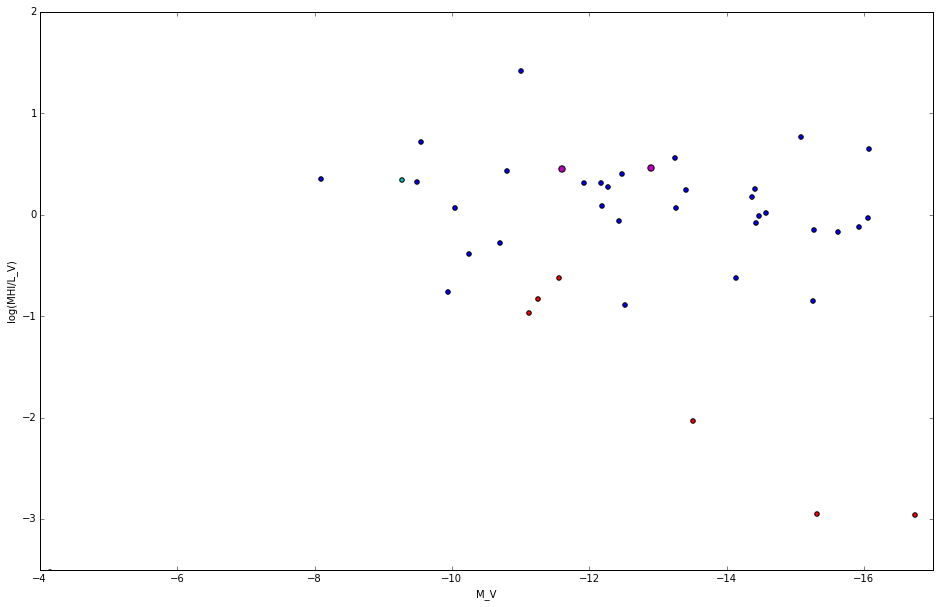

In [105]:
plt.scatter(sfingMV, np.log10(sfingMHI) - mag2lmstar(sfingMV), c='b')
plt.scatter(passiveMV, np.log10(passiveMHI) - mag2lmstar(passiveMV), c='r')
plt.scatter([leopMV.value], np.log10([leopMHI.value]) - mag2lmstar([leopMV.value]), c='c')
plt.scatter(piscsMV, np.log10(piscsMHI) - mag2lmstar(piscsMV), c='m',s=40)
plt.xlim(-4, -17)
plt.ylim(-3.5,2)
plt.xlabel('M_V')
plt.ylabel('log(MHI/L_V)')